# Biological introduction

## Interhepatic Cholangiocarcinoma
Intrahepatic Cholangiocarcinoma (ICC) is a type of malignant solid tumour arising from the [bile ducts in the liver](https://doi.org/10.2147/OTT.S93629). Clinical management of the disease is difficult, with only a minority of cases available for surgical treatment (tumor resection, ~15%), most studies reporting systemic chemotherapy to be ineffective in extending lifespan or improving other clinical outcomes (TODO find sources), and with reports showing moderately successful clinical outcomes of hepatic arterial infusion chemotherapy using generic chemotherapeutics such as floxuridine or yttrium-90 (TODO find sources). The primary clinical outcome that can be achieved with such localized chemotherapy is downsizing of the tumor, which can allow for successful re-evaluation of patient's eligibility for resection. Targeted therapy was shown to be [effective in isolated cases](https://doi.org/10.3978/j.issn.2078-6891.2013.031), but devising eligibility criteria for existing targeted therapies remains an open challenge (TODO link some papers on molecular biomarkers for tageted therapies, or maybe Ruibin's paper if it's already available). Given limited efficacy of existing treatment options, and poor prognosis, with median survival of only about 6 months, there's a pressing need to develop new treatments. This proves to be difficult as ICC is characterised by a high level of molecular diversity, and has a number of clinical presentations. Due to recent experimental advances it has become possible to study molecular diversity of thousands of individual cancer cells, using an approach called droplet-based single cell RNA-seq (scRNA-seq).

## Single cell RNA-seq

A single cell droplet-based RNA-seq system uses a microfluidics device, thousands of barcoding beads, and a DNA sequencer to inspect molecular identity of individual cells. The microfluidics device allows for the formation of nanolitre droplets, some of which capture individual cancer cells, some of which capture individual barcoding beads, and some of which capture both a cell and a bead. This final group of droplets containing a cell and a bead participate in further analysis, which consists of cell lysis (breaking cells apart), RNA capture by the barcoding bead, reverse transcription into DNA an DNA amplification. The resulting collection of DNA molecules directly corresponds to the original RNA molecules captured by the beads, with each DNA molecule directly traceable to a single cell, through a cell-specific barcode (CB), and even to a single RNA molecule, through unique molecular identifier (UMI). All DNA molecules are then combined together, and sequenced using a next-generation sequencer (NGS). The resulting dataset, after several steps of pre-processing can be represented as a matrix, with the number of columns equal to the number of (human) genes, the number of rows equal to the number of detected cells, and integer values representing number of the individual RNA molecules expressed per cell per gene. This, in effect, represents a state of the art measurment of the molecular identity of the cell -- and in the context of ICC, will allow us to learn more about development of this cancer, confirm existing understanding of the molecular basis of the disease, and hopefully bring new insights, such as candidate treatment targets.

# Computational introduction

The analysis is carried out in [scanpy](https://github.com/theislab/scanpy), a fantastic open-source single-cell Python package.

There is a number of supportive packages we have to import, most importantly `anndata`, a matrix-based data structure, which can be used to store transcript counts per cell per gene.

Anndata supports multiple layers of the count matrix, which can be used to store counts of both mature, spliced mRNA molecules, and nascent, unspliced ones. Layers make it possible to use scanpy in analysing not only the position of individual cells, but also the direction of their development, dubbed "RNA velocity". This is achieved with the `scvelo` package.

In [1]:
import numpy as np
import pandas
import scanpy as sc
import anndata
import json
import matplotlib.pyplot as plt
import scvelo as scv
import os
import requests
import shutil
import boto3
%matplotlib inline

/home/picrin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Downloading and loading the loom file

We've already carried out alignement, barcode correction, some initial filtering, and spliced and unspliced transcript counting, using respectively the `STAR` aligner, `dropest` barcode correction and `velocyto` to produce the loom file (we do not use its computed velocity field). We can download the loom file and load it into an `anndata` object using scanpy.

In [2]:
cell_line = "C1239"
filename = "{}.loom".format(cell_line)
filepath = os.path.join("data", "cell_lines", filename)

In [3]:
adata = sc.read_loom(filepath)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


It's a good idea to poke around a little bit and check out our data before we analyse it.

In [4]:
with open("barcodes/{}.umi.rds_barcodes.txt".format(cell_line)) as f:
    wu_lin_barcodes = set([i.strip() for i in f])
our_barcodes = [i.split(":")[-1][:-1] for i in adata.obs.index]
our_barcodes_set = set(our_barcodes)
print(len(our_barcodes), len(wu_lin_barcodes), len(our_barcodes_set.intersection(wu_lin_barcodes)))
adata = adata[[i in wu_lin_barcodes for i in our_barcodes], :]
adata

2000 1495 1495


View of AnnData object with n_obs × n_vars = 1495 × 58395 
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

Let's note that `n_obs` is the number of individual cancer cells -- after barcode correction and initial quality filtering. `n_vars` is the number of detected genes. Both dimensions will be reduced by further quality checks.

Let's check out the layers

In [5]:
adata.layers.as_dict()

{'ambiguous': <1495x58395 sparse matrix of type '<class 'numpy.float32'>'
 	with 638944 stored elements in Compressed Sparse Row format>,
 'matrix': <1495x58395 sparse matrix of type '<class 'numpy.float32'>'
 	with 4634343 stored elements in Compressed Sparse Row format>,
 'spliced': <1495x58395 sparse matrix of type '<class 'numpy.float32'>'
 	with 3721064 stored elements in Compressed Sparse Row format>,
 'unspliced': <1495x58395 sparse matrix of type '<class 'numpy.float32'>'
 	with 861189 stored elements in Compressed Sparse Row format>}

As we can see, there are multiple matrices stored in the `anndata` object. `spliced` and `unspliced` are the ones we'll be interested in for the velocity computation.

Layers are only used for RNA velocity. Other types of analysis are carried out using just a single matrix, stored as a field in the `anndata` object, e.g. `adata.X`

In [6]:
type(adata.X)

anndata.base.SparseCSRView

As we can see, this is identical to the "spliced" matrix from the layers. This makes sense as mature (spliced) messenger RNA (mRNA) is what we're most interested in, and should abundant, since most experimental techniques (including our technique, Drop-seq) enrich for the polyA cap, characteristic of mature mRNA, and using a polyT cDNA sequence present at the end of the bead used to capture RNA.

In [7]:
np.allclose(adata.X.toarray(), adata.layers.as_dict()["spliced"].toarray())

True

We can inspect the column (gene) information. Accession is a unique, immutable gene identifier, which tends to be more machine-friendly than still evolving gene nomenclature (e.g. CELF1 is sometimes referred to as CUGBP1). Chromosome, End, Start and Strand uniquely identify the position of the gene in a reference human chromosome (we use GRCh38).

In [8]:
adata.var[:10]

,Accession,Chromosome,End,Start,Strand
WASH7P,ENSG00000227232,1,29570,14404,-
MIR6859-1,ENSG00000278267,1,17436,17369,-
FAM138A,ENSG00000237613,1,36081,34554,-
AL627309.1,ENSG00000238009,1,133723,89295,-
AL627309.3,ENSG00000239945,1,91105,89551,-
AL627309.6,ENSG00000268903,1,135895,135141,-
AL627309.7,ENSG00000269981,1,137965,137682,-
AL627309.2,ENSG00000239906,1,140339,139790,-
AL627309.5,ENSG00000241860,1,173862,141474,-
RNU6-1100P,ENSG00000222623,1,157887,157784,-


In [9]:
"CUGBP1" in adata.var_names

False

In [10]:
"CELF1" in adata.var_names

True

row (cell) information is less interesting, since at the beginning of the analysis we know very little about any particular cell -- the only information we have is the cellular barcode. In fact, the whole analysis can be viewed as transferring existing information we have about genes to information about cells, all done via the count matrices.

In [11]:
adata.obs[:10]

""
C1239_OEJFK:AACAGGGCAATAx
C1239_OEJFK:AACAGTTCGAGGx
C1239_OEJFK:AAGTGGTAGTAGx
C1239_OEJFK:AACAATCCGAAAx
C1239_OEJFK:AAGCACCTTACAx
C1239_OEJFK:AACTTGGTGCCAx
C1239_OEJFK:AACCCAACTCTTx
C1239_OEJFK:AATCACCACATCx
C1239_OEJFK:AAGTTCGGCGAGx
C1239_OEJFK:AAGATTCGTAAGx


# Write to file

We can save the dataset locally, using a scanpy-native file format, to make it easily available for downstream analysis.

In [12]:
adata.write(os.path.join("data", "00_{}.h5ad".format(cell_line)))

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'Chromosome' as categorical
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'Strand' as categorical


# Exercises

1. Using numpy, compute a total number of genes per cell, and save it in the `obs` variable (Hints: read about `np.ravel` and `np.sum`, you'll have to work with `adata.X`).
2. Plot your results from the exercise 1 using either a histogram or a violin plot.

You can find solutions to the exercises in the next notebook, `01_filtering_and_normalisation.ipynb`

# What to read next

The next notebook, `01_filtering_and_normalisation.ipynb` is quite technical, unless you find normalisation particularly interesting, I'd suggest to skip it and go straight to `02_PCA_plots_and_stemness_analysis.ipynb`

# Filtering and normalisation

We have to import all libraries and load up the scanpy file from the previous step

In [13]:
import numpy as np
import pandas
import scanpy as sc
import anndata
import json
import matplotlib.pyplot as plt
import scvelo as scv
import os
import requests
import shutil
%matplotlib inline

First, let's make all gene names unique

In [14]:
old_names = set(adata.var_names)

In [15]:
adata.var_names_make_unique()

In [16]:
new_names = set(adata.var_names)

Inspection of gene names suggests that most genes requiring disambiguation are small non-coding RNAs. This could be a by-product of our alignment pipeline, but given that we're mostly interested in mRNA, this shouldn't be a big issue for our analysis.

In [17]:
list(new_names - old_names)[:10]

['RF00019-203',
 'RF00019-635',
 'RF00019-82',
 'RF00019-164',
 'RF00019-236',
 'RF00017-14',
 'RF00019-326',
 'RF00601-1',
 'RF00019-679',
 'RF00017-46']

In [18]:
len(new_names - old_names)

1543

The first thing we can learn about cancer cells in our dataset is the total count of RNA moleclues (often referred to as UMI)

In [19]:
UMI_count = adata.X.sum(1)

In [20]:
UMI_count

matrix([[4925.],
        [3803.],
        [4558.],
        ...,
        [5658.],
        [2998.],
        [6028.]], dtype=float32)

In [21]:
UMI_count.shape

(1495, 1)

In [22]:
counts = np.ravel(UMI_count)
counts.shape

(1495,)

In [23]:
adata.obs["n_counts"] = counts

We can visualise our newly computed information about cells using a violin plot

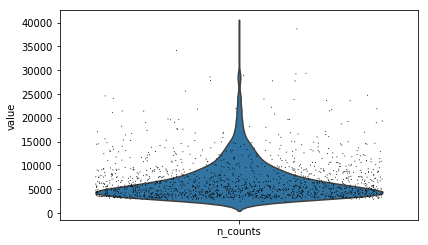

In [24]:
sc.pl.violin(adata, ['n_counts'], jitter=0.4)

Very highly expressed cells are likely doublets or triplets or some other types of artifacts. We can filter out, say 5% of most expressed cells.

In [25]:
cutoff = sorted(counts)[int(len(counts)*0.95)]

In [26]:
adata = adata[adata.obs['n_counts'] < cutoff, :]

We can visualise our data again

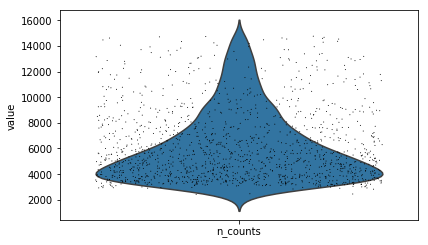

In [27]:
sc.pl.violin(adata, ['n_counts'], jitter=0.4)

Lowly expressed cells are also a concern -- these can indicate ruptured or apoptotic cell remnants. Earlier stages of the pipeline have already filtered some of these cells, but we should still be cautions.

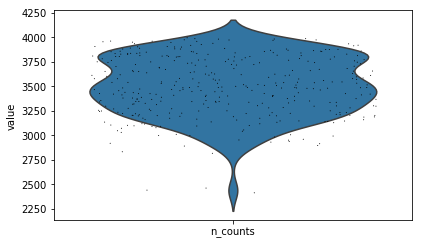

In [28]:
sc.pl.violin(adata[adata.obs["n_counts"] < 4000, : ], ['n_counts'], jitter=0.4)

As we can see, very few cells are expressed at a level of 1000 UMI or below. Given that these cells are most likely low quality/ ruptured/ apoptotic we can filter them out.

In [29]:
adata = adata[adata.obs["n_counts"] > 1000, :]

In [30]:
adata.shape

(1420, 58395)

We can also look at most highly expressed genes.

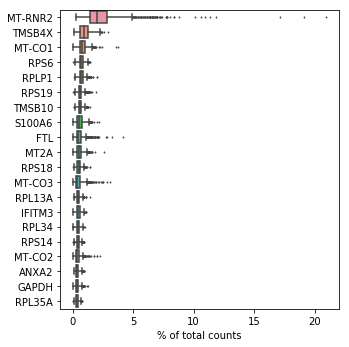

In [31]:
sc.pl.highest_expr_genes(adata, n_top=20)

As we can see, the list contains a lot of mitochondrial genes ("MT-"). This can be a cause of concern, as this can be indicative of a high proportion of ruptured cells. Previous studies using healthy tissue have filtered out cells with more than 5% mitochondrial RNA.

Let's first identify mitochondrial genes

In [32]:
mito_genes = adata.var_names.str.startswith('MT-')

And compute their percentage

In [33]:
adata.obs["percent_mito"] = np.ravel(np.sum(adata[:, mito_genes].X, axis=1)) / adata.obs["n_counts"]

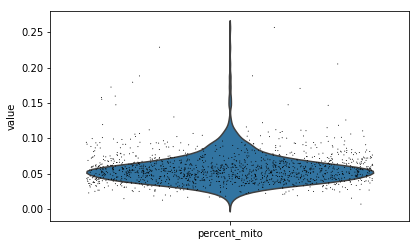

In [34]:
sc.pl.violin(adata, ['percent_mito'], jitter=0.4)

As can be seen in the plot, rejecting all cells with more than 5% mitochondrial RNA would significantly reduce our sample. However, given that these are cancer cells, and mitochondrial function is [known to be dirupted](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4371788/) in cancer, we will adjust the usual threshold to 10%.

In [35]:
adata = adata[adata.obs['percent_mito'] < 0.1, :]

In [36]:
adata

View of AnnData object with n_obs × n_vars = 1372 × 58395 
    obs: 'n_counts', 'percent_mito'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

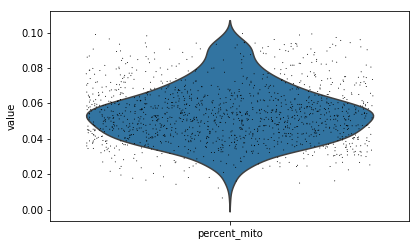

In [37]:
sc.pl.violin(adata, ['percent_mito'], jitter=0.4)

Next, we can filter out cells which express few genes, and filter out genes which are present in only small number of cells. We will save the original list of genes separately to allow for investigation even after reduction of the number of genes.

In [38]:
# cells expressing at least 0.5% of ~20000 genes
sc.pp.filter_cells(adata, min_genes=round(20000 * 0.005))
genes_accessions = adata.var["Accession"]
adata.uns['before_filter_rare_genes'] = list(genes_accessions.index), list(genes_accessions)

# genes expressed in at least 5% of all cells
sc.pp.filter_genes(adata, min_cells=round(adata.shape[0] * 0.05)) # 100

In [39]:
adata.X.eliminate_zeros() # Removes explicit zeros
n_genes = adata.X.getnnz(axis=1) # Counts explicit values

# or, slightly less efficient but still more efficient than making a dense array
#np.ravel((adata.X != 0).sum(axis=1))

In [40]:
n_genes

array([2044, 1682, 2019, ..., 2231, 1472, 2422], dtype=int32)

These filters compute an addition observation, `n_genes` (and an additional column `n_columns`). This is all that we've managed to learn about our cells so far.

In [41]:
adata.obs[:10]

,n_counts,percent_mito,n_genes
C1239_OEJFK:AACAGGGCAATAx,4925.0,0.046497,2135
C1239_OEJFK:AACAGTTCGAGGx,3803.0,0.071785,1777
C1239_OEJFK:AAGTGGTAGTAGx,4558.0,0.057701,2112
C1239_OEJFK:AACAATCCGAAAx,3700.0,0.054595,1758
C1239_OEJFK:AACTTGGTGCCAx,7215.0,0.057519,2521
C1239_OEJFK:AACCCAACTCTTx,13708.0,0.051357,3891
C1239_OEJFK:AATCACCACATCx,4186.0,0.063545,1891
C1239_OEJFK:AAGATTCGTAAGx,13351.0,0.021721,3884
C1239_OEJFK:AATAAATAGGACx,5079.0,0.050010,2377
C1239_OEJFK:AAGTGGCAAATTx,11824.0,0.050068,3522


Despite all the filtering, a number of gene counts is still a major source of variation, and given that the origin of this variation is believed to be mostly technical, and biologically uninteresting, we will attempt to remove it by rescaling total gene count in each cell to 10000

In [42]:
3000 * 2000

6000000

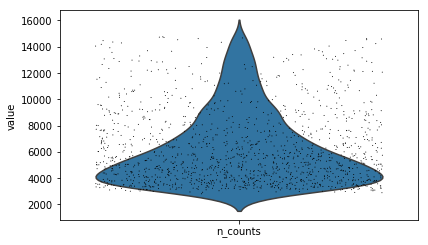

In [43]:
sc.pl.violin(adata, ['n_counts'], jitter=0.4)

In [44]:
before_normalising = adata.X.sum(1)

In [45]:
before_normalising

matrix([[4832.],
        [3706.],
        [4464.],
        ...,
        [5549.],
        [2934.],
        [5909.]], dtype=float32)

In [46]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

In [47]:
adata.X.sum(1)

matrix([[10000.   ],
        [10000.   ],
        [10000.   ],
        ...,
        [10000.   ],
        [10000.   ],
        [ 9999.999]], dtype=float32)

Prior experience working with microarray and bulk RNA-seq data suggests that many effects are linear in the logarithm of the UMI count (or probe intensity, or read coverage), and it's therefore advised to log the data as part of the normalisation process.

In [48]:
sc.pp.log1p(adata)

In [49]:
adata.raw = adata

In [50]:
adata.X.sum(1)

matrix([[3040.4255],
        [2747.1287],
        [3080.1045],
        ...,
        [3112.0657],
        [2660.1848],
        [3265.4302]], dtype=float32)

In [51]:
genes_accessions = adata.var["Accession"]
adata.uns['before_filter_nonvariable_genes'] = list(genes_accessions.index), list(genes_accessions)

One method to reduce dimensionality, employed also by Seurat and CellRanger software, computes dispersion, which is the ratio of variance and mean of (logged) genes across all cells. Highly variable genes can be identified based on this parameter, and selected for further analysis. Additionally, highly expressed genes are unlikely to be helpful in the analysis, as they most likely come from non-coding RNA, and we can also filter them out.

In [52]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=4, min_disp=0.01)

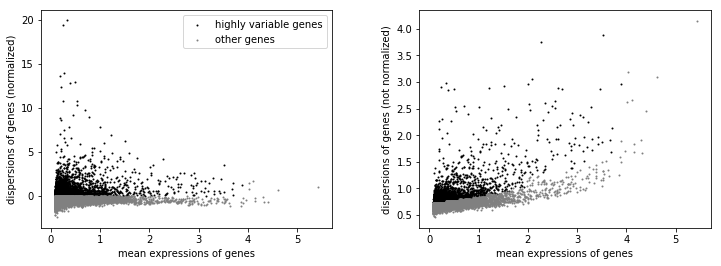

In [53]:
sc.pl.highly_variable_genes(adata)

In [54]:
adata = adata[:, adata.var['highly_variable']]

Gene variance on its own can be a source of unwanted signal in the data. All genes are scaled to unit variance and values exceeding std=10 can be clipped to extremes.

In [55]:
sc.pp.scale(adata, max_value=10)

In [56]:
after_normalising = adata.X.sum(1)

In [57]:
after_normalising

array([  27.144838,  -87.195625,  -66.88721 , ...,  -26.44371 ,
       -144.7761  ,  244.9401  ], dtype=float32)

In [58]:
#sc.pp.normalize_per_cell(adata, counts_per_cell_after=10)

In [59]:
adata.X.sum(1)

array([  27.144838,  -87.195625,  -66.88721 , ...,  -26.44371 ,
       -144.7761  ,  244.9401  ], dtype=float32)

In [60]:
import scipy.stats
scipy.stats.pearsonr(before_normalising.T.tolist()[0], after_normalising.T.tolist())

(0.39300311198167565, 6.718867820596805e-52)

# Write to file

In [61]:
"01_{}.h5ad".format(cell_line)

'01_C1239.h5ad'

In [62]:
adata.write(os.path.join("data", "01_{}.h5ad".format(cell_line)))

# What to read next

The next notebook `02_stemness_analysis.ipynb` carries out the actual single cell analysis.

In [63]:
import numpy as np
import pandas
import scanpy as sc
import anndata
import json
import matplotlib.pyplot as plt
import scvelo as scv
import os

%matplotlib inline

# Dimensionality reduction and stemness analysis 

We've already pre-processed our data, and are ready to begin analysis. One of the first challenges is the very high dimensionality of our dataset. It's difficult to search for patterns when we can't easily "see" or "interact" with our data, and high dimensionality is a hindrance, with potentially thousands of plots that would have to be anlaysed and reasoned about. A common technique to solve this problem is dimensionality reduction, which can be either linear (preserve angles and distances in the original space, carrying out minimally lossy projection onto the reduced 2d or 3d space; e.g. PCA) or non-linear ("roughly" preserving angles and distances at least in a "global" sense, but with more adventurous characterics locally; e.g tSNE or UMAP).

In [64]:
adata

AnnData object with n_obs × n_vars = 1372 × 3218 
    obs: 'n_counts', 'percent_mito', 'n_genes'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'before_filter_rare_genes', 'before_filter_nonvariable_genes'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

# Principal component analysis (PCA)

First, we're going to reduce the dimensionality of the data by running principal component analysis (PCA). PCA is one of the least advanced dimensionality reduction techniques, which can be a virtue, as one can easily develop strong geometric intuition about the behaviour of the algorithm, making it much easier to reason about and troubleshoot any issues. Developing geometric intuition about non-linear techniques is not impossible, especially if one is willing to perform a range of simulations looking at [various kinds of simulated datasets, testing different types of parameters](https://distill.pub/2016/misread-tsne/).

In [65]:
sc.tl.pca(adata, svd_solver='arpack')

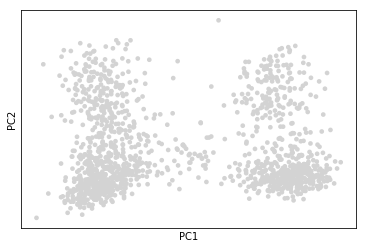

In [66]:
sc.pl.pca(adata)

As we can see there's a significant dispersion along both principal components. Some investigation demonstrates that total, pre-normalisation transcript count per cell ("n_counts", as computed in the normalisation step), is still a major factor differentiating cells.

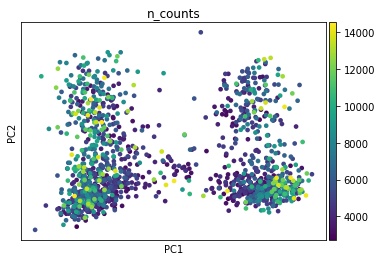

In [67]:
sc.pl.pca(adata, color='n_counts')

An easy, but inaccurate, explanation is that those cells which have more transcripts are represented by longer transcription vectors and therefore are positioned farther away from the origin of the coordinate system (as represented by a hypothetical cell with a transcription of every gene equal to zero), and therefore are represented by more extreme values along the major PCs. The reason this explanation is inaccurate is two-fold: 
1. Earlier in the analysis we normalised our cells, by rescaling total transcription count (or, mathematically speaking, rescaling all vectors to a common length with respect to the L1 metric), so we wouldn't expect (L2) vector lengths to play major role in the investigation downstream of normalisation.
2. Assuming the effect is purely due to vector length, with no bias towards any particular group of genes, we should observe a uniformly bright outer ring with a dark inside -- which clearly isn't the case. 

Unfortunately, it emerges that subsequent step of logging the data, although biologically sound, destroys the normalisation, and produces cells with L1 length highly correlated with the original, pre-normalisation length, which possibly refutes the first of the two remarks. The interplay of length normalisation, logging, and bias due to confounding is subtle, and is discussed separately in the `Appendix01_normalisation_issues.ipynb`.

# Regressing out cell size confounder

A common approach to deal with bias due to confounders is "regressing out" a confounder from the dataset. The approach works by fitting a linear model that predicts expression levels of all the genes, from a (group of) confounder(s), and derives "denoised" signal from the resulting residuals. This often seems to result in a desirable "dissipation" of the signal introduced by the confounder evenly across the dataset. We can confirm this effect on our dataset by re-computing our low-dimensional PCA embedding.

In [68]:
sc.api.pp.regress_out(adata, keys="n_counts")
sc.pp.scale(adata)

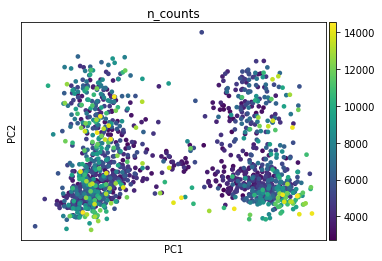

In [69]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color='n_counts')

# PCA captures small amount of variance in the data

Unfortunately, 2-dimensional PCA embedding captures only about 1% of the total variance. This isn't much, which highlights the need for improved dimensionality reduction techniques, and should be kept in mind when trying to interpret these plots.

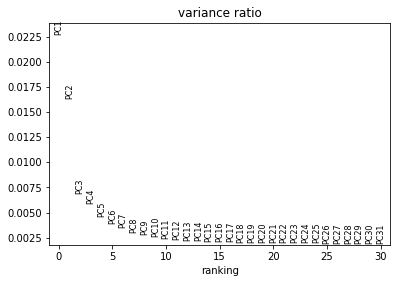

In [70]:
sc.pl.pca_variance_ratio(adata)

# Regressing out cell cycle 

Many single cell studies (including this one) focus primarily on development of a population of cells. Least developed, most immature cells are called "progenitor" cells, in contrast with "differentiated cells". One hopes that a large proportion of variation, as visualised in the PCA or tSNE/UMAP plots is due to differentiation. However, differentiation is just one of many processes, which are simulataneously co-occuring in a population of cells. Many of these processes will be outside of the interest of the study. One prominent example is cell cycle. Cells, and especially cancer cells, continuously divide, and the stage of cell division has a big effect on the cell's transcription profile. Interestingly, after cell division, daughter cells usually have a good understanding of which development stage they are supposed to be at: the level of differentation is "saved" before cell division using DNA methylation and gets "restored" after division, with the daughter cells continuing differentation along the path charted by the parent cell.

Cell cycle biomarkers of [two cell cycle stages (TODO link to  Tirosh et al, 2015.)](http://example.com) were previously identified. There are two sets of biomarkers described in the paper: for the S cell stage, and for the G2/M stages. We can compute a cumulative cell cycle score for each of those biomarker sets, and regress out unwanted source of variation.

In [71]:
with open(os.path.join("data", "s_genes")) as f:
    cell_cycle_s_genes = set(map(str.strip, f))

In [72]:
len(cell_cycle_s_genes)

43

In [73]:
with open(os.path.join("data", "g2m_genes")) as f:
    cell_cycle_g2m_genes = set(map(str.strip, f))

In [74]:
len(cell_cycle_g2m_genes)

54

This is how we can get a list of all non-filtered genes

In [75]:
current_genes = set(adata.var.index)

Unfortunately, not all genes are still present, as some were filtered out in the normalisation stage, and some possibly contain out-of-date gene names.

In [76]:
len(cell_cycle_s_genes)

43

In [77]:
len(cell_cycle_s_genes - current_genes)

14

In [78]:
len(cell_cycle_g2m_genes)

54

In [79]:
len(cell_cycle_g2m_genes - current_genes)

10

We can check which of the genes are not present in our original, pre-filtered dataset.

In [80]:
full_genes = set(adata.uns["before_filter_rare_genes"][0])

In [81]:
cell_cycle_s_genes - full_genes

{'MLF1IP'}

In [82]:
cell_cycle_g2m_genes - full_genes

{'FAM64A', 'HN1'}

Consulting literature we can find correct names for these genes

In [83]:
cell_cycle_g2m_genes.remove("FAM64A")
cell_cycle_g2m_genes.add("PIMREG")

In [84]:
cell_cycle_g2m_genes.remove("HN1")
cell_cycle_g2m_genes.add("JPT1")

In [85]:
cell_cycle_s_genes.remove("MLF1IP")
cell_cycle_s_genes.add("CENPU")

In [86]:
cell_cycle_genes = cell_cycle_g2m_genes.union(cell_cycle_s_genes)

In [87]:
cell_cycle_genes - full_genes

set()

We can compute cell cycle scores

In [88]:
sc.tl.score_genes_cell_cycle(adata, s_genes=cell_cycle_s_genes.intersection(current_genes), g2m_genes=cell_cycle_g2m_genes.intersection(current_genes))

And plot them onto our original 2-dimensional PCA embedding

... storing 'phase' as categorical


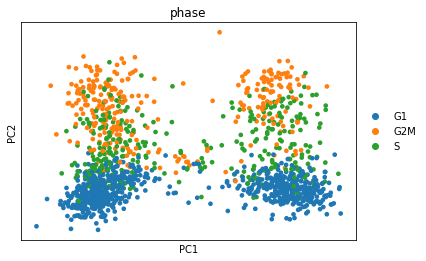

In [89]:
sc.pl.pca_scatter(adata, color='phase')

Or creating a new embedding, focusing only on the cell-cycle genes.

In [90]:
adata_cc_genes = adata[:, list(cell_cycle_genes.intersection(current_genes))]

In [91]:
# Due to a suspected bug in scanpy we have to re-initialise adata_cc_genes
adata_cc_genes = anndata.AnnData(X=adata_cc_genes.X, var=adata_cc_genes.var, obs=adata_cc_genes.obs)

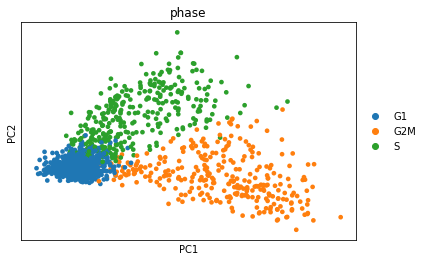

In [92]:
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase')

As we can see, regressing these scores out seems to remove cell cycle as a source of variation in this experiment.

In [93]:
sc.pp.regress_out(adata, ['S_score', 'G2M_score'])
sc.pp.scale(adata)

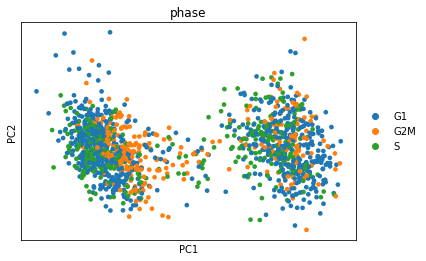

In [94]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_scatter(adata, color='phase')


# Try to detect CNV using expression values

In [95]:
adata.X.shape

(1372, 3218)

In [96]:
adata.var.query('index=="CD24"')

,Accession,Chromosome,End,Start,Strand,n_cells,highly_variable,means,dispersions,dispersions_norm
CD24,ENSG00000272398,6,106975627,106969831,-,226,True,0.324768,1.077348,3.069496


In [97]:
chromosomes = ["chr{i}".format(i=i) for i in range(1, 23)] + ["chrM", "chrX", "chrY"] 

chromo_to_band = {}
with open("cytoBand.txt") as f:
    for line in f:
        try:
            chromosome, start, end, band, _ = line.rstrip().split()
        except ValueError:
            chromosome, start, end, band = line.rstrip().split()
        if chromosome in chromosomes:
            bands = chromo_to_band.setdefault((chromosome, band[0]), []).append((int(start), int(end)))

In [99]:
!pip install intervaltree

  Running setup.py bdist_wheel for intervaltree ... done
  Stored in directory: /home/picrin/.cache/pip/wheels/08/99/c0/5a5942f5b9567c59c14aac76f95a70bf11dccc71240b91ebf5
Successfully built intervaltree
  Found existing installation: sortedcontainers 1.5.7
    Uninstalling sortedcontainers-1.5.7:
      Successfully uninstalled sortedcontainers-1.5.7
You are using pip version 9.0.1, however version 19.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [100]:
import intervaltree

In [101]:
it = intervaltree.IntervalTree()
for chr_band, intervals in chromo_to_band.items():
    for interval in intervals:
        it[interval[0]:interval[1]] = chr_band

In [102]:
it

IntervalTree([Interval(0, 16569, ('chrM', 'g')), Interval(0, 300000, ('chrY', 'p')), Interval(0, 2200000, ('chr9', 'p')), Interval(0, 2300000, ('chr1', 'p')), Interval(0, 2300000, ('chr6', 'p')), Interval(0, 2300000, ('chr8', 'p')), Interval(0, 2800000, ('chr11', 'p')), Interval(0, 2800000, ('chr3', 'p')), Interval(0, 2800000, ('chr7', 'p')), Interval(0, 2900000, ('chr18', 'p')), Interval(0, 3000000, ('chr10', 'p')), Interval(0, 3100000, ('chr21', 'p')), Interval(0, 3200000, ('chr12', 'p')), Interval(0, 3400000, ('chr17', 'p')), Interval(0, 3600000, ('chr14', 'p')), Interval(0, 4200000, ('chr15', 'p')), Interval(0, 4300000, ('chr22', 'p')), Interval(0, 4400000, ('chr2', 'p')), Interval(0, 4400000, ('chr5', 'p')), Interval(0, 4400000, ('chrX', 'p')), Interval(0, 4500000, ('chr4', 'p')), Interval(0, 4600000, ('chr13', 'p')), Interval(0, 5100000, ('chr20', 'p')), Interval(0, 6900000, ('chr19', 'p')), Interval(0, 7800000, ('chr16', 'p')), Interval(300000, 600000, ('chrY', 'p')), Interval(6

In [137]:
def detect_band(coords):
    results = []
    for interval in it[coords[0]: coords[1]]:
        chromosome, arm = interval.data
        if chromosome == "chr6":
            results.append(arm)
    if not results:
        return None
    if len(results) == 1:
        return results[0]
    else:
        return results[0]
        print("Arm info: {}".format(results))

In [144]:
import collections
empty_counter = 0
c = collections.Counter()
location_to_gene = {}
for i, rows in adata.var.iterrows():
    coords = sorted([rows["Start"], rows["End"]])
    chromosome = "chr" + rows["Chromosome"]
    c[chromosome] += 1
    band = detect_band(coords)
    if band == None:
        empty_counter += 1
    location_to_gene.setdefault((chromosome, band), []).append(i)

In [171]:
all_genes_sum = []
chromosomes = []
for chr_arm, genes in location_to_gene.items():
    selected_genes = adata[:, genes]
    try:
        sum_selected_genes = selected_genes.X.sum(axis=1)
        all_genes_sum.append(sum_selected_genes)
        chromosomes.append(chr_arm)
    except numpy.AxisError:
        pass

In [179]:
data = np.vstack(all_genes_sum)

In [180]:
data.shape

(50, 1372)

In [178]:
import seaborn

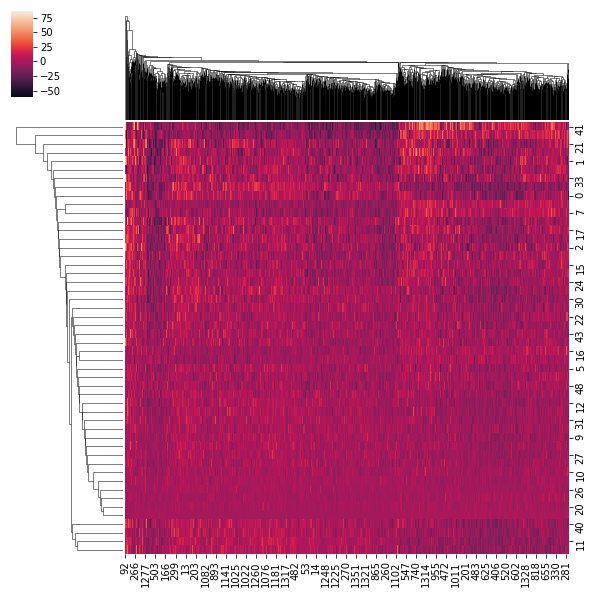

In [181]:
seaborn.clustermap(data)